In [1]:
import pandas as pd
import tensorflow as tf
import librosa
from sklearn.model_selection import train_test_split
import numpy as np



2024-04-17 18:31:42.302962: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 18:31:42.326060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 18:31:42.326079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 18:31:42.326829: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 18:31:42.332487: I tensorflow/core/platform/cpu_feature_guar

In [2]:
dataset_df = pd.read_csv('dataset.csv').to_numpy()
sounds_dataset = dataset_df[:, 0]
sr = 0
for i in range(len(sounds_dataset)):
    sounds_dataset[i], sr = librosa.load(f'Noisy-sounds/{sounds_dataset[i]}.wav')

label_dataset = dataset_df[:, 1]
for i in range(len(label_dataset)):
    label_dataset[i], sr = librosa.load(f'Clean-sounds/{label_dataset[i]}.wav')

X_train, X_test, y_train, y_test = train_test_split(sounds_dataset, label_dataset, test_size=0.1, random_state=42)



In [3]:
def to_spectogram(sound):
    stft = librosa.stft(sound.astype(np.float64), n_fft = 256, hop_length=128)
    stft = np.abs(stft)
    db = librosa.amplitude_to_db(stft, ref=np.max)
    return db
    # print(db)
    # librosa.display.specshow(db, y_axis='log', x_axis='time')


In [4]:
spectogram_train = []
for x in X_train:
    spectogram_train.append(to_spectogram(x))
spectogram_label = []
for x in y_train:
    spectogram_label.append(to_spectogram(x))
spectogram_val = []
for x in X_test:
    spectogram_val.append(to_spectogram(x))
spectogram_val_label = []
for x in y_test:
    spectogram_val_label.append(to_spectogram(x))



In [5]:
max_len = 0
for x in spectogram_train:
    max_len = max(max_len, len(x[0]))
for x in spectogram_label:
    max_len = max(max_len, len(x[0]))
for x in spectogram_val:
    max_len = max(max_len, len(x[0]))
for x in spectogram_val_label:
    max_len = max(max_len, len(x[0]))
print(max_len)

863


In [6]:
def pad_vector(vec):
    for i in range(len(vec)):
        vec[i] = np.pad(vec[i], ((0, 0), (0, max_len - len(vec[i][0]))))
    return vec

In [7]:
spectogram_train = pad_vector(spectogram_train)
spectogram_label = pad_vector(spectogram_label)
spectogram_val = pad_vector(spectogram_val)
spectogram_val_label = pad_vector(spectogram_val_label)


In [8]:
spectogram_train = np.array(spectogram_train)
spectogram_label = np.array(spectogram_label)
spectogram_val = np.array(spectogram_val)
spectogram_val_label = np.array(spectogram_val_label)

In [9]:
spectogram_train = spectogram_train / -80
spectogram_label = spectogram_label / -80
spectogram_val = spectogram_val / -80
spectogram_val_label = spectogram_val_label / -80

In [10]:
print(spectogram_train.shape)

(5675, 129, 863)


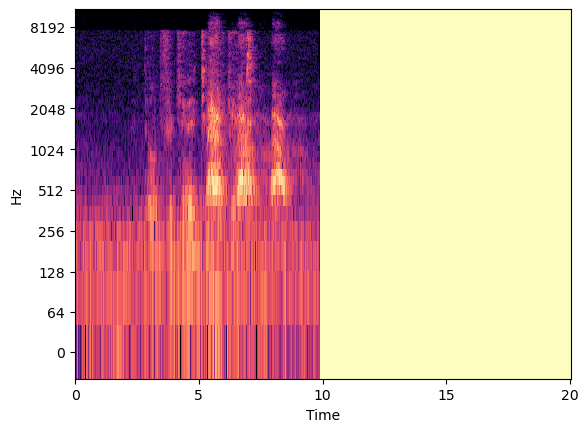

In [11]:
test = spectogram_train[0] * -80
librosa.display.specshow(test, y_axis='log', x_axis='time')

In [12]:
to_spectogram(X_train[0])

array([[-48.87827506, -30.76394261, -50.2082908 , ..., -36.83999055,
        -38.3575437 , -37.96956034],
       [-37.838238  , -26.51338154, -31.8250759 , ..., -30.86195013,
        -31.79447788, -41.75488833],
       [-34.41648103, -28.29701582, -24.03368903, ..., -31.10269617,
        -33.0766842 , -53.91818598],
       ...,
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ]])

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow import keras
# Define the dimensions of the input data
input_shape = (129, 863)  # MNIST dataset has 28x28 grayscale images

# go through 10 Conv2D layers to modify the input image
#Encoder part
input_data = keras.layers.Input(shape=input_shape)

#use lstm to encode the input data
encoder = LSTM(256, return_sequences=True)(input_data)

#Decoder part
decoder = LSTM(863, return_sequences=True)(encoder)


model = Model(inputs=input_data, outputs=decoder)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 129, 863)]        0         
                                                                 
 lstm_10 (LSTM)              (None, 129, 256)          1146880   
                                                                 
 lstm_11 (LSTM)              (None, 129, 863)          3866240   
                                                                 
Total params: 5013120 (19.12 MB)
Trainable params: 5013120 (19.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history = model.fit(spectogram_train, spectogram_label,
                epochs=15,
                batch_size=16,
                shuffle=True,
                validation_data=(spectogram_val, spectogram_val_label),)

Epoch 1/15


2024-04-17 18:51:24.620460: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


  3/355 [..............................] - ETA: 11s - loss: 0.2601 - mae: 0.3863 

2024-04-17 18:51:24.899822: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f55acd9d5b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-17 18:51:24.899859: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-04-17 18:51:24.905716: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713369084.966520   74443 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


355/355 [==============================] - 10s 25ms/step - loss: 0.0250 - mae: 0.0862 - val_loss: 0.0132 - val_mae: 0.0601
Epoch 2/15
355/355 [==============================] - 8s 23ms/step - loss: 0.0127 - mae: 0.0576 - val_loss: 0.0107 - val_mae: 0.0524
Epoch 3/15
355/355 [==============================] - 8s 23ms/step - loss: 0.0107 - mae: 0.0522 - val_loss: 0.0104 - val_mae: 0.0526
Epoch 4/15
355/355 [==============================] - 8s 23ms/step - loss: 0.0097 - mae: 0.0492 - val_loss: 0.0090 - val_mae: 0.0476
Epoch 5/15
355/355 [==============================] - 8s 22ms/step - loss: 0.0090 - mae: 0.0471 - val_loss: 0.0086 - val_mae: 0.0460
Epoch 6/15
355/355 [==============================] - 8s 22ms/step - loss: 0.0084 - mae: 0.0454 - val_loss: 0.0084 - val_mae: 0.0453
Epoch 7/15
355/355 [==============================] - 8s 22ms/step - loss: 0.0082 - mae: 0.0444 - val_loss: 0.0079 - val_mae: 0.0436
Epoch 8/15
355/355 [==============================] - 8s 22ms/step - loss: 0.00

In [27]:
sample, sr = librosa.load('Noisy-sounds/Sound1.wav')
sample = to_spectogram(sample)
sample = np.array(sample)
sample = np.pad(sample, ((0, 0), (0, max_len - len(sample[0]))))
sample = np.expand_dims(sample, axis=0)
sample = sample / -80

In [28]:
prediction = model.predict(sample)
print(prediction.shape)
print(np.min(prediction))

1/1 [==============================] - 0s 368ms/step
(1, 129, 863)
-0.23174766


(110336,)


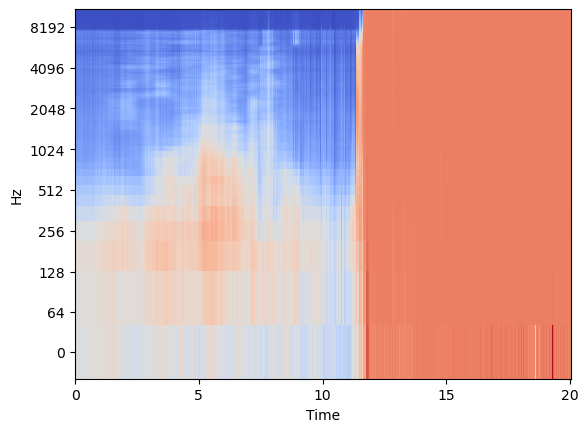

In [29]:
import soundfile as sf
#prediction = librosa.db_to_amplitude(prediction)
prediction = np.squeeze(prediction)
prediction = prediction * -80
librosa.display.specshow(prediction, y_axis='log', x_axis='time')
prediction = librosa.istft(prediction, hop_length=128, n_fft=256)
print(prediction.shape)


In [ ]:
print(np.max(prediction))

In [ ]:
target, sr = librosa.load('Clean-sounds/1087_MTI_DIS_XX.wav')
target = to_spectogram(target)
librosa.display.specshow(target, y_axis='log', x_axis='time')

In [30]:
sf.write('test_denoised.wav', prediction, sr)